# 1. 데이터 분할

## 1.1 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('/content/drive/MyDrive/2주차 데이터/train.csv')
test = pd.read_csv('/content/drive/MyDrive/2주차 데이터/test.csv')

## 1.2 X, Y 분리
x와 y도 분리해두세요.  
train에만 일단 적용해주세요. 우린 아직 test데이터를 보지 못했습니다.

In [73]:
Y = data.price
X = data.drop(columns= 'price')

In [ ]:
print(Y.head())
X.head()

0     70000
1    100500
2     65800
3     30500
4     30500
Name: price, dtype: int64


,dong,apt,exclusive_use_area,floor,transaction_year,until_trans,sin_date,cos_date
0,사직동,광화문풍림스페이스본(9-0),95.88,6,0,5,-1.000000e+00,-1.836970e-16
1,사직동,광화문풍림스페이스본(9-0),108.55,11,0,5,-2.449294e-16,1.000000e+00
2,사직동,광화문풍림스페이스본(9-0),94.51,1,0,5,-2.449294e-16,1.000000e+00
3,수송동,로얄팰리스스위트,42.87,8,0,8,-1.000000e+00,-1.836970e-16
4,수송동,로얄팰리스스위트,39.67,15,0,8,1.000000e+00,3.061617e-16


## 1.3 validation set 분할 - 첫번째
사이킷런의 train_test_split을 통해 train데이터를 8:2로 validation set을 만들어주세요.  
즉 train중에서 train/val이 있고, test set이 따로 존재합니다.  
test set은 전처리 과정에서 절대 사용되지 않을 예정입니다.

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
train_X, valid_X, train_Y, valid_Y = train_test_split(X, Y, test_size=0.2, random_state=1234)

## 1.4 질문
이렇게 데이터를 나눌 경우 어떤 문제가 발생할 수 있을까요?    
힌트) 현재 데이터는 관측된 시간이 존재합니다.

Y값에는 transaction_year라는 거래 년도가 들어갑니다.  
거래 년도는 값들끼리 서로 영향을 주고 받는 변수입니다.
이런 특성을 고려하지 않은 채 데이터를 나누면 종속변수 값들이 서로 상관관계를 갖는 문제가 발생합니다.

## 1.5 validation set 분할 - 두번째
transaction_year == 4인 행을 validation으로 지정해서 분할하세요.

In [74]:
valid = data[data.transaction_year==4]
valid_y = valid['price']
valid_x = valid.drop(columns = 'price')

train = data[data.transaction_year!=4]
train_y = train['price']
train_x = train.drop(columns = 'price')

## 1.6 캣부스트 인코딩

In [8]:
! pip install category_encoders

     |████████████████████████████████| 81kB 3.3MB/s 


In [9]:
from category_encoders.cat_boost import CatBoostEncoder

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


방금까지 trainset을 분할했죠? 그 분할된 것을 캣부스트 인코딩의 인자로 받을 겁니다.  
train에서 분할된 train을 인코딩을 위한 학습으로 사용해서, 이를 validation_x에 적용합니다.  
해당 결과를 head()를 통해 보여주세요.

In [75]:
cbe_encoder = CatBoostEncoder()

train_cbe = cbe_encoder.fit_transform(train_x, train_y)
val_cbe = cbe_encoder.transform(valid_x)

val_cbe.head()

,dong,apt,exclusive_use_area,floor,transaction_year,until_trans,sin_date,cos_date
2451,89176.597368,86280.203194,107.91,14,4,9,-1.000000e+00,-1.836970e-16
2452,89176.597368,86280.203194,151.81,10,4,9,-1.000000e+00,-1.836970e-16
2453,89176.597368,86280.203194,94.51,2,4,9,-2.449294e-16,1.000000e+00
2454,89176.597368,86280.203194,94.28,12,4,9,-2.449294e-16,1.000000e+00
2455,103789.156533,107170.755379,145.96,13,4,13,-1.000000e+00,-1.836970e-16


# 2. 릿지 회귀 (Ridge Regression)

## 2.1 상관계수 플랏
캣부스트 인코딩을 시행한 튜닝을 위한 trainset에 대해 상관계수플랏을 그리세요.  
해석해주세요. 릿지 회귀가 잘 작동할까요?

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns 

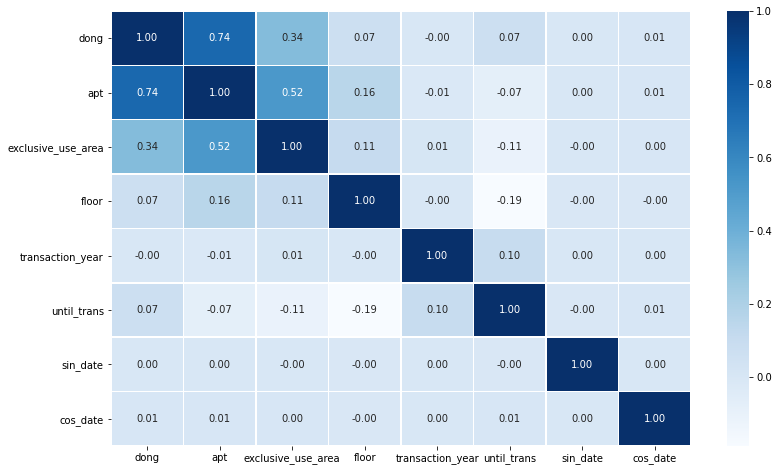

In [12]:
plt.figure(figsize=(13,8))
sns.heatmap(data = train_cbe.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

dong과 apt, apt와 exlcusive_use_area간의 상관관계가 굉장히 높아 다중공선성의 위험이 있어 보입니다. 하지만 데이터 수에 비해 변수의 수가 그리 크지 않아 릿지 리그레션이 잘 작동할지는 모르겠습니다.



## 2.2 해석과 무관하게 일단 릿지 튜닝
mse를 비교해서 튜닝을 진행하세요.  
릿지의 튜닝파라미터 알파는 0.00001, 0.0001, 0.001, 0.01, 0.1로 설정합니다.  
알파가 클수록 강한 페널티입니다.  
튜닝결과를 시각화해주세요.

In [71]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from math import sqrt

In [76]:
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1]
ridge = Ridge()
rmse=[]

for a in alphas:
  ridge.set_params(alpha = a)
  ridge.fit(train_cbe,train_y)
  pred = ridge.predict(val_cbe)
  rmse.append(sqrt(mean_squared_error(valid_y,pred)))

## 2.3 튜닝결과 시각화

[14777.881419502048, 14777.881419592419, 14777.881420496145, 14777.881429533427, 14777.88151990623]


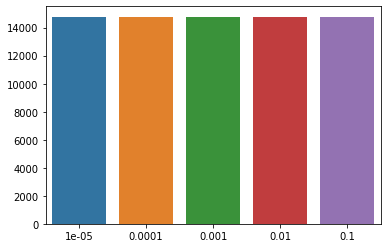

In [78]:
sns.barplot(x=alphas, y=rmse)
print(rmse)

## 2.4 해석
튜닝 결과에 대한 플랏을 보고 해석을 해주세요.

패널티가 커져도 rmse에 큰 영향이 없는 것으로 보아 튜닝이 잘 안된 것 같습니다.  



##2.5 그냥 선형 모형으로!
그냥 linear regression을 튜닝을 위한 trainset에 적합시키고, validation set에 대한 rmse를 계산하세요.  

linear regression은 다른 튜닝 파라미터를 필요로하지 않습니다.  
ridge와의 validation rmse를 비교했을 때, 어떤 모형을 쓰는 것이 나을지 말해주세요.

In [64]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr = LinearRegression()

lr.fit(train_cbe,train_y)
pred = lr.predict(val_cbe)
rmse = sqrt(mean_squared_error(valid_y,pred))
print(rmse)

14777.88141949239


linear regression이 ridge regression보다 rmse가 작으므로 선형 모형을 쓰는 것이 더 나을 것 같습니다.

# 3. LightGBM

In [ ]:
! pip install lightgbm

## 3.1 LightGBM 이해
모형에 대해 아주 기본적인 이해는 필요하겠죠?   
LGBM의 특징/장점/문제점을 적어주세요.  

20-01 데마팀 클린업 3주차 혹은 또 다른 데마팀 클린업을 보셔도 괜찮습니다.
구글링해도 잘 나옵니다.

LGBM이란 leaf-wise방식을 사용한 트리 기반 알고리즘으로 기존 트리 알고리즘과 다르게 트리의 균형을 맞추지 않고도 리프 노드를 계속 분할할 수 있습니다.  
장점: 학습하는 데 걸리는 시간이 적으며 메모리 사용량도 적습니다.   
문제점: 적은 양의 데이터셋을 이용할 경우 오버피팅을 야기할 가능성이 큽니다. 

## 3.2 LGBM 튜닝
LGBM의 튜닝파라미터는 많습니다.  
max_depth, learning_rate, lambda, min_child_samples 등 다양한데, 패키지에서는 learning rate만 튜닝하도록 하겠습니다.  
[0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.99] 이렇게 튜닝해주세요.  
부스팅에서는 일단 learning rate과 iteration의 trade off를 적절하게 고려해줘서 학습속도를 맞춰준다음, 세부적인 튜닝을 하는게 일반적입니다.  
더하고 싶으면 해서 더 좋은 성능을 내셔도 됩니다! 보통 enumerate를 통해 파라미터를 묶어줘서 진행합니다.

In [46]:
from lightgbm import LGBMModel,LGBMRegressor

In [61]:
rate = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.99]
lgb = LGBMRegressor()
rmse=[]

for a in rate:
  lgb.set_params(learning_rate = a)
  lgb.fit(train_cbe,train_y)
  pred = lgb.predict(val_cbe)
  rmse.append(sqrt(mean_squared_error(valid_y,pred)))

## 3.3 튜닝결과 시각화

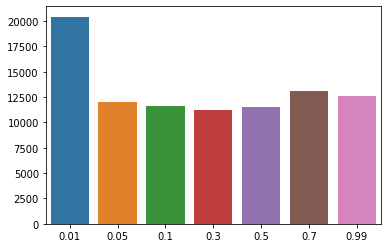

In [62]:
sns.barplot(x=rate, y=rmse)

learning rate가 0.3일 때 rmse가 가장 낮습니다.

## 3.4 튜닝에 대하여 알아보자
우리가 한 튜닝방식은 그리드 서치(Grid Search)방법입니다. 다른 방법으로는 Random Search와 Bayesian Optimization 방법이 있습니다.

세 가지 방법에 대해서 간단히 설명하고, 장단점을 말해주세요.  
요즘에는 Neural Process 기반의 Optimization이란 방법도 활발히 연구중이라던데...그냥 그렇다구요 ㅎㅎㅎ 원래 Bayesian Optimization이 Gaussian Process 기반인데, 이걸 뛰어넘는 성능이래요 암튼~

그리드 서치는 튜닝파라미터 값들을 일정 간격을 두고 선정해서 각각에 대해 측정, 가장 좋은 성능을 내는 파라미터 값을 선정하는 방법입니다.  
장점: 모든 경우의 수를 살펴볼 수 있습니다.  
단점: 살펴보고자 하는 경우의 수가 많아질수록 탐색 시간이 급격히 증가합니다. 중요하지 않은 파라미터를 탐색하는 시간이 많습니다.
  
랜덤 서치는 정해진 파라미터 범위 내에서 랜덤하게 일부 파라미터 값만 측정하는 방법입니다.  
장점: 그리드 서치에서의 불필요한 반복을 줄여 탐색을 더 빨리 할 수 있습니다.  
단점: 하지만 랜덤하게 탐색하기 때문에 정확도가 떨어진다는 단점이 있습니다.
  
베이지안 최적화는 이전 학습 결과를 반영해 목적 함수 f(x)를 만들고, 함숫값 f(x)를 최대로 만드는 최적의 x를 찾는 방법입니다.  
장점: 선험 지식을 활용하기 때문에 더 효율적인 탐색이 가능합니다.  
단점: 좋은 목적 함수를 만들기 위해서는 많은 양의 샘플이 필요합니다. 또한 성능이 파라미터 값들에 과도하게 민감하다는 단점도 있습니다.

# 4. test set

## 4.1 test set 불러오기

In [59]:
test_Y = test.price
test_X = test.drop(columns= 'price')

## 4.2 캣부스트 인코딩
전체 train set에 대해 캣부스트 인코딩을 시행해주세요.  
인자에는 train_x/train_y/test_x가 들어갈겁니다.

In [66]:
cbe_encoder = CatBoostEncoder()

train_cbe = cbe_encoder.fit_transform(X, Y)
test_cbe = cbe_encoder.transform(test_X)

test_cbe.head()

,dong,apt,exclusive_use_area,floor,transaction_year,until_trans,sin_date,cos_date
0,91827.227742,89369.051084,70.80,1,5,10,-1.000000e+00,-1.836970e-16
1,91827.227742,89369.051084,94.51,8,5,10,-2.449294e-16,1.000000e+00
2,91827.227742,89369.051084,160.85,11,5,10,-2.449294e-16,1.000000e+00
3,91827.227742,89369.051084,94.51,6,5,10,1.000000e+00,3.061617e-16
4,91827.227742,89369.051084,136.40,3,5,10,1.000000e+00,3.061617e-16


## 4.3 최적의 파라미터 적합
2와 3의 결과에서 최적의 파라미터(모델)을 전체 trainset에 대해 적합하세요.

In [68]:
#linear regression
lr = LinearRegression()

lr.fit(train_cbe,Y)
pred = lr.predict(test_cbe)
rmse_lr = sqrt(mean_squared_error(test_Y,pred))


#lgbm
lgb = LGBMRegressor(learning_rate = 0.3)

lgb.fit(train_cbe,Y)
pred = lgb.predict(test_cbe)
rmse_lgb = sqrt(mean_squared_error(test_Y,pred))

## 4.4 test set에 대해 평가
두 모델을 test set에 대해 평가해서 비교하세요.

In [69]:
print(rmse_lr,rmse_lgb)

16350.627412822772 12620.169008688932


lgbm모델이 linear regression보다 rmse가 더 낮다는 걸 알 수 있습니다.